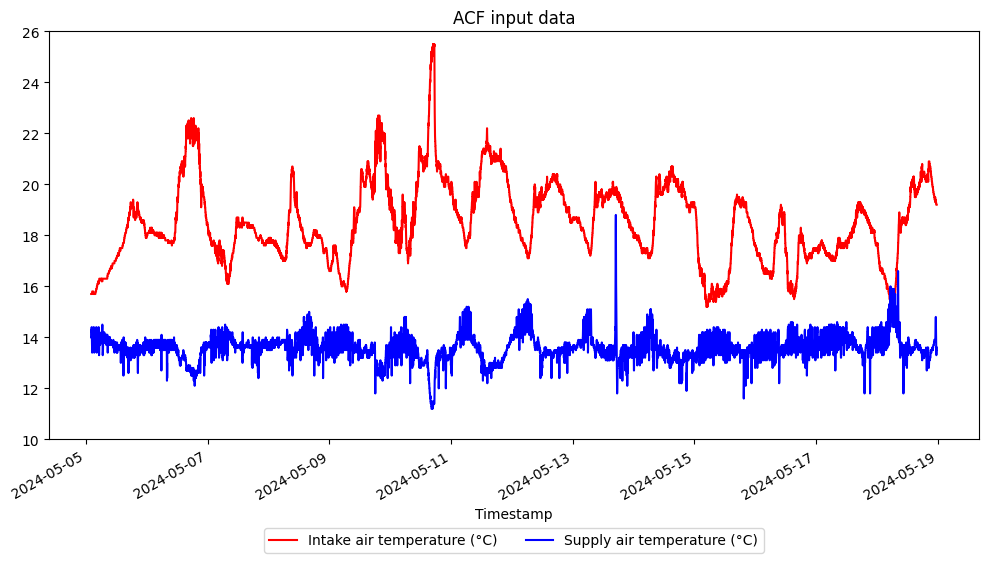

In [2]:
#Import the library's
import importlib
import Universial_Data_Functions
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm 
import matplotlib.pyplot as plt 

#Check if there is a connection with the SQL server
if SQL_Connect.Connection_With_DB: 
    #Create an object that is capable of getting,transforming and visualizing data
    data_obj = SQL_Connect.Visualaize_Data(sql_handler= SQL_Connect.cursor,timestamp_begin= '\'2024-05-05\'',database_name='822Raw',minutes_amount = 20000)
    #Create a list with the desired data points
    to_get = [
            'AC[2].AH[1].AI[1].ATT[1].IV_PV_SCL',
            'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',
        ]
    #Create a dictronary to translate the points to a more readable format (used for visualization)
    custom = {
        'AC[2].AH[1].AC[1].WCV[1].IV_PV' : 'Cold water valve (%)',
        'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL' : 'Supply air temperature (°C)',
        'AC[2].AH[1].AM[1].ATT[1].IV_PV_SCL' : 'Mixing air temperature (°C)',
        'AC[2].AH[1].FM[1].FSC[1].IV_PV_SPD' : 'Supply fan speed (%)',
        'AC[2].AH[1].AI[1].ATT[1].IV_PV_SCL' : 'Intake air temperature (°C)',
        'AC[2].AH[1].AC[1].WTT[1].IV_PV_SCL' : 'Cold water inlet temeprature (°C)',
        'AC[2].AH[1].AC[1].WTT[2].IV_PV_SCL' : 'Cold water outlet temeprature (°C)',
        'AC[2].AH[1].AR[1].ART[1].IV_PV_SCL' : 'Return air humidity (%)',
        'AC[2].AH[1].AH[1].SHU[1].IV_PV':  'Steam humidifier output (%) ',
        'AC[2].AH[1].AS[1].ART[1].IV_PV_SCL': 'Supply air humidity (%)'
    }
    #Create a dataframe based on the desired data points
    data_obj.Create_DF(requests=to_get,fill_zero_room= True,fill_zero_other= True,AH_in_table= False)
    data_obj.filter_na()
    #Set the lower and the upper range for the plot
    data_obj.lower_range = 10
    data_obj.upper_range = 26
    #Create a plot of the data
    data_obj.Plot_Data(legend_heigth= -0.2,title='ACF input data',custom_names=custom,light_mode= True )

Prepare the data for modeling

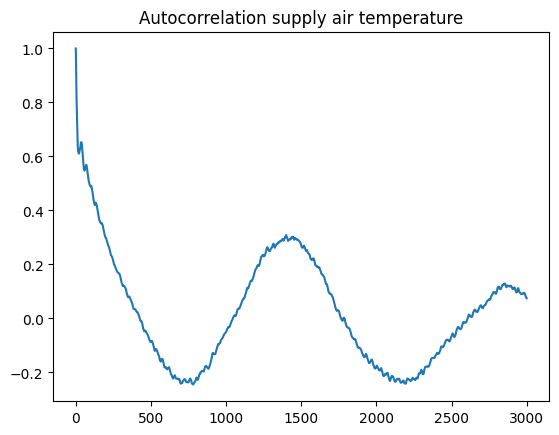

In [3]:
#Do an autocorrelation analysis on the supply air temperature
acf_values2 = sm.tsa.acf(data_obj.df['AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL'], nlags=3000) 
#Plot the auto autocorrelation
plt.title('Autocorrelation supply air temperature') 
plt.plot(acf_values2) 

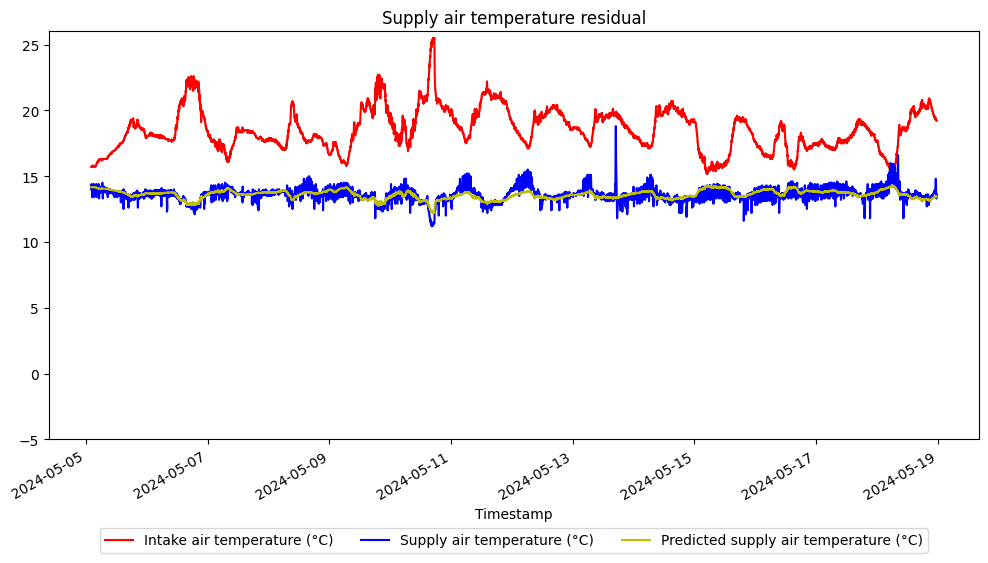

In [4]:
#Reset the range range for the plot
data_obj.lower_range = -5
data_obj.upper_range = 26
#Make a prediction of the supply temperature based on the intake temperature
X = sm.add_constant(data_obj.df['AC[2].AH[1].AI[1].ATT[1].IV_PV_SCL']) 
model = sm.OLS(data_obj.df['AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL'], X).fit() 
data_obj.df['Predicted supply air temperature (°C)'] = model.predict(X) 
#Subtract the predictided supply temperature from the actual supply temperature, therfore eliminating the intake temperature compensation controlled by the PLC
data_obj.df['Supply air temperature residual (°C)'] = data_obj.df['AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL'] - data_obj.df['Predicted supply air temperature (°C)'] 
#Plot the dataframe
data_obj.Plot_Data(legend_heigth= -0.2,title='Supply air temperature residual',custom_names=custom,light_mode= True)


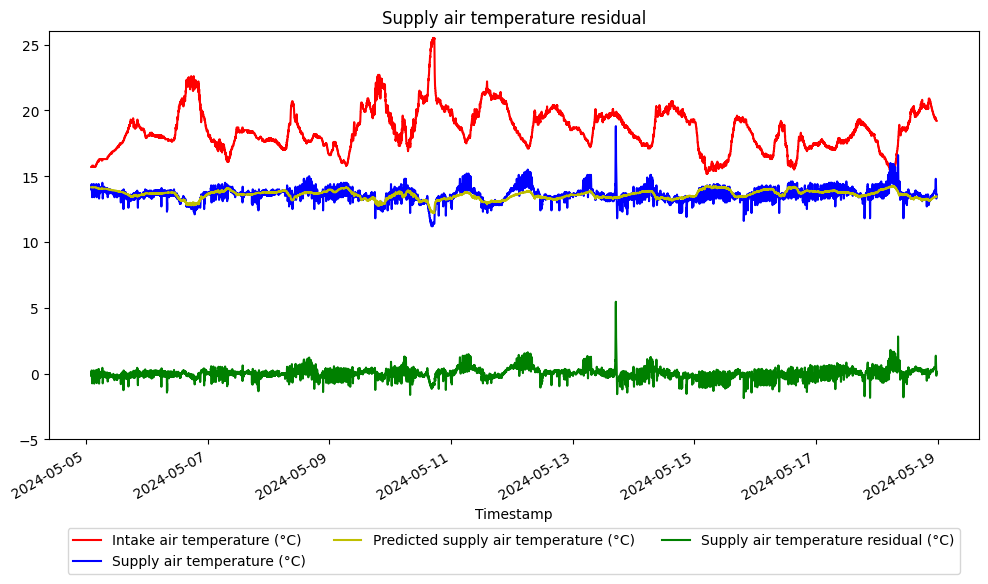

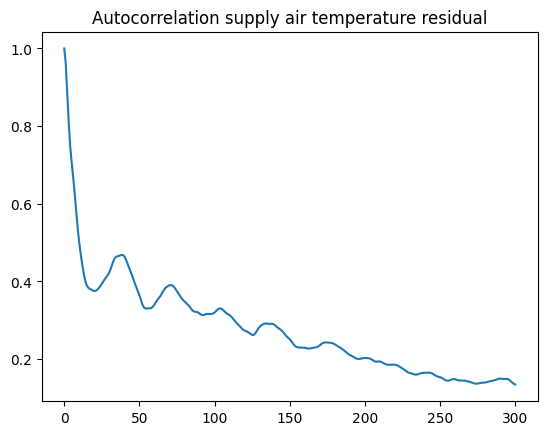

In [6]:
import matplotlib.pyplot as plt 
acf_values = sm.tsa.acf(data_obj.df['Supply air temperature residual (°C)'], nlags=300) 
plt.title('Autocorrelation supply air temperature residual')  # Adding a title to the plot
plt.plot(acf_values) 

/home/Digital_Twin/Finished/Correlation_Matrix.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.matrix = self.matrix.fillna(0)


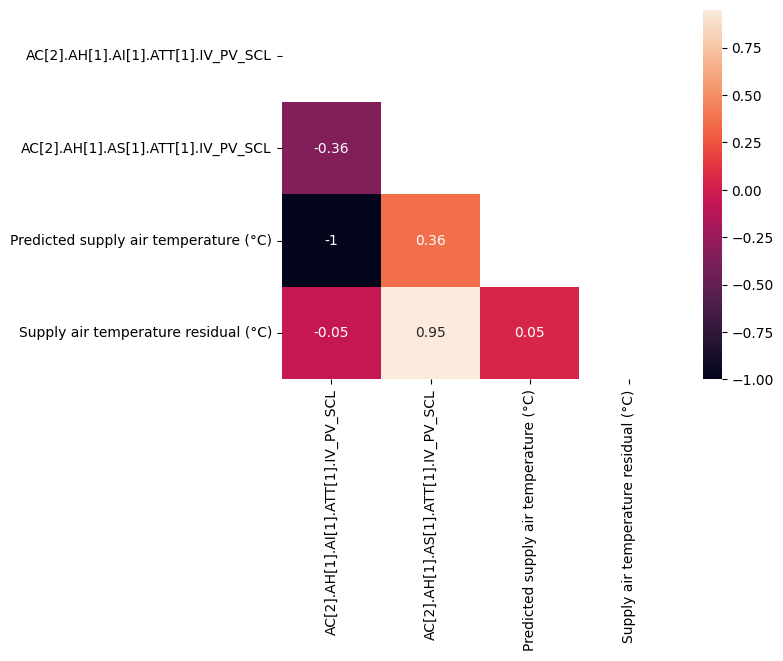

In [8]:
import Correlation_Matrix
#Create a correlation matrix
correltation = Correlation_Matrix.Correlation_Matrix(df_in= data_obj.d)
#print(correltation.matrix)
correltation.correlation_matrix(time =2500, lag= 120,plot_heatmap= True,custom _)
